In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from matplotlib import pyplot as plt
from tabulate import tabulate

In [2]:
dataset = pd.read_csv('../data/interim/dataset.csv')

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

dataset['user_id'] = user_encoder.fit_transform(dataset['user_id'])
dataset['item_id'] = item_encoder.fit_transform(dataset['item_id'])

In [3]:
ratings = dataset['rating'].copy()
dataset.drop(columns=['rating'], inplace=True)
dataset['rating'] = ratings / 5.0
dataset['age'] /= dataset['age'].max()
dataset['year'] /= dataset['year'].max()
dataset = dataset.drop(columns=['timestamp'])
dataset.head()

,user_id,item_id,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,rating
0,195,239,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.6
1,195,254,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.4
2,195,109,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.8
3,195,23,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.8
4,195,378,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0.8


In [4]:
dataset.columns

Index(['user_id', 'item_id', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'FilmNoir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'SciFi', 'Thriller', 'War',
       'Western', 'year', 'month', 'age', 'sex', 'occupation_administrator',
       'occupation_artist', 'occupation_doctor', 'occupation_educator',
       'occupation_engineer', 'occupation_entertainment',
       'occupation_executive', 'occupation_healthcare', 'occupation_homemaker',
       'occupation_lawyer', 'occupation_librarian', 'occupation_marketing',
       'occupation_none', 'occupation_other', 'occupation_programmer',
       'occupation_retired', 'occupation_salesman', 'occupation_scientist',
       'occupation_student', 'occupation_technician', 'occupation_writer',
       'rating'],
      dtype='object')

In [5]:
class RecommenderDataset(Dataset):
    """
    dataset for the recommender system
    """
    def __init__(self, dataframe):
        self.data = dataframe.values
        self.columns = dataframe.columns

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32)

In [6]:
class EmbeddingRecommenderModel(nn.Module):
    """
    embedding model for recommender system
    args:
        user_size: number of users
        item_size: number of items
        users_features: number of features for users
        item_features: number of features for items
        embedding_size: size of the embedding
    """
    def __init__(self, user_size, item_size, users_features, item_features, embedding_size=16):
        super(EmbeddingRecommenderModel, self).__init__()
        self.user_embedding = nn.Embedding(user_size, embedding_size)
        self.item_embedding = nn.Embedding(item_size, embedding_size)
        
        self.fc1 = nn.Linear(embedding_size * 2 + item_features + users_features - 1, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
    
    def forward(self, user_id, item_id, users_info, items_info):
        user_embed = self.user_embedding(user_id)
        item_embed = self.item_embedding(item_id)
        x = torch.cat([user_embed, item_embed, users_info, items_info], dim=1)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return x

Epoch 1/7, Training Loss: 0.06050197891287717, Validation Loss: 0.04469962241459626
Epoch 2/7, Training Loss: 0.043101626613482776, Validation Loss: 0.041373324692008176
Epoch 3/7, Training Loss: 0.04008721763697954, Validation Loss: 0.03958375521703445
Epoch 4/7, Training Loss: 0.03812617537403396, Validation Loss: 0.03876919000979188
Epoch 5/7, Training Loss: 0.03689632730083427, Validation Loss: 0.03822872920329517
Epoch 6/7, Training Loss: 0.035950297734093084, Validation Loss: 0.03766888738112542
Epoch 7/7, Training Loss: 0.03527068829819982, Validation Loss: 0.03713397555728368


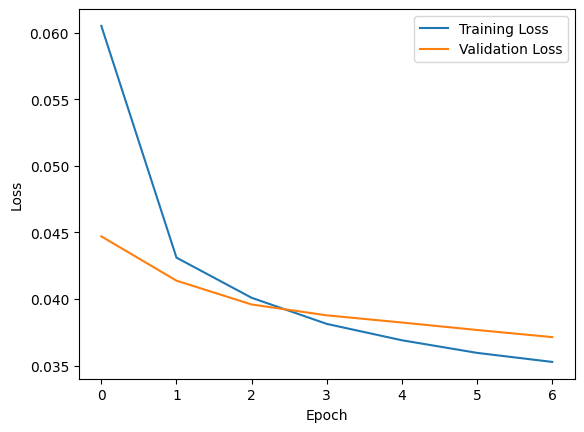

In [32]:
class RecommenderSystem:
    """
    recommender system class
    """
    def __init__(self, dataframe, batch_size=64, lr=0.001, epochs=7, validation_split=0.2):
        """
        initialize the recommender system
        args: 
            dataframe: the dataframe containing the dataset
            batch_size: the batch size for training
            lr: learning rate
            epochs: number of epochs to train
            validation_split: the validation split for training
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        user_size = dataframe['user_id'].nunique()
        item_size = dataframe['item_id'].nunique()
        self.model = EmbeddingRecommenderModel(user_size, item_size, 23, 21).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_size = batch_size
        self.epochs = epochs
        self.dataset = dataframe

        train_data, val_data = train_test_split(dataframe, test_size=validation_split, random_state=42)
        self.train_dataset = RecommenderDataset(train_data)
        self.val_dataset = RecommenderDataset(val_data)


    def train(self):
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf')
        train_losses = []
        val_losses = []

        for epoch in range(self.epochs):
            # training
            self.model.train()
            running_loss = 0.0
            # train the model for one epoch
            for batch in train_loader:
                batch = batch.to(self.device)
                inputs, targets = batch[:, :-1], batch[:, -1]
                # get the inputs and targets
                user_ids = inputs[:, 0].long()
                item_ids = inputs[:, 1].long()
                item_info = inputs[:, 2:22].long()
                user_info = inputs[:, 22:].long()
                self.optimizer.zero_grad()
                # forward pass
                outputs = self.model(user_ids, item_ids, item_info, user_info)
                loss = self.criterion(outputs.squeeze(), targets)
                # backward pass
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            train_losses.append(running_loss / len(train_loader))

            # validation
            self.model.eval()
            val_loss = 0.0

            # turn off gradients for validation
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch.to(self.device)
                    inputs, targets = batch[:, :-1], batch[:, -1]
                    # get the inputs and targets
                    user_ids = inputs[:, 0].long()
                    item_ids = inputs[:, 1].long()
                    item_info = inputs[:, 2:22].long()
                    user_info = inputs[:, 22:].long()
                    # forward pass
                    outputs = self.model(user_ids, item_ids, item_info, user_info)
                    val_loss += self.criterion(outputs.squeeze(), targets).item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}/{self.epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_loss}")

            # save the model if validation loss has decreased
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), '../models/best_pytorch_model.pth')

        # plot the training and validation losses
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    
    def predict_top_k(self, user_id):
        self.model.eval()

        # get the unique item IDs
        item_ids = torch.tensor(self.dataset['item_id'].unique(), dtype=torch.long).to(self.device)

        # repeat the user ID for each item to create inputs for prediction
        user_ids = torch.full_like(item_ids, user_id, dtype=torch.long).to(self.device)

        # other features are set to dummy values
        item_info = torch.zeros((len(item_ids), 20), dtype=torch.long).to(self.device)
        user_info = torch.zeros((len(item_ids), 23), dtype=torch.long).to(self.device)

        # make predictions for all items
        with torch.no_grad():
            predictions = self.model(user_ids, item_ids, item_info, user_info).squeeze()

        return predictions , item_ids


    def print_recommendations(self, ratings, movies, user_id, k=5):
        predictions, item_ids = self.predict_top_k(user_id)

        # get sorted indices
        _, top_indices = torch.topk(predictions, len(predictions))
        top_item_ids = item_ids[top_indices]
        top_scores = predictions[top_indices]

        recommendations = list(zip(top_item_ids.cpu().numpy(), top_scores.cpu().numpy()))

        # remove films that are already in ratings for the given user_id
        rated_movies = ratings[ratings['user_id'] == user_id]['item_id'].values

        # get top k recommendations
        recommendations = [(item_id, score) for item_id, score in recommendations if item_id not in rated_movies][:k]

        if not recommendations:
            print("No new recommendations. User has already watched all top-k movies.")
            return

        table_data = []
        headers = ["Item ID", "Title Name", "Year", "Score"]

        for item_id, score in recommendations:
            title = movies[movies['item_id'] == item_id]['title'].values[0]
            year = movies[movies['item_id'] == item_id]['date'].values[0]

            table_data.append([item_id, title, year, score * 5])

        print(tabulate(table_data, headers=headers, tablefmt="grid"))



recommender_system = RecommenderSystem(dataset)
recommender_system.train()

In [12]:
genres = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'FilmNoir', 'Horror', 'Musical', 'Mystery', 'Romance', 'SciFi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../data/raw/ml-100k/u.item', sep='|', encoding='latin-1')
movies.columns = ['item_id', 'title', 'date', 'release_date', 'url'] + genres

csv_file_path = '../data/raw/ml-100k/u.data'
ratings = pd.read_csv(csv_file_path, delimiter='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

In [16]:
recommender_system.print_recommendations(ratings, movies, 500, 10)

+-----------+--------------------------------------------------------+-------------+---------+
|   Item ID | Title Name                                             | Year        |   Score |
+===========+========================================================+=============+=========+
|       114 | Wallace & Gromit: The Best of Aardman Animation (1996) | 05-Apr-1996 | 4.77888 |
+-----------+--------------------------------------------------------+-------------+---------+
|       834 | Halloween: The Curse of Michael Myers (1995)           | 01-Jan-1995 | 4.61764 |
+-----------+--------------------------------------------------------+-------------+---------+
|       148 | Ghost and the Darkness, The (1996)                     | 11-Oct-1996 | 4.6146  |
+-----------+--------------------------------------------------------+-------------+---------+
|       969 | Winnie the Pooh and the Blustery Day (1968)            | 01-Jan-1968 | 4.56157 |
+-----------+-------------------------------------

In [19]:
recommender_system.print_recommendations(ratings, movies, 15, 3)

+-----------+--------------------+-------------+---------+
|   Item ID | Title Name         | Year        |   Score |
+===========+====================+=============+=========+
|       124 | Lone Star (1996)   | 21-Jun-1996 | 4.96368 |
+-----------+--------------------+-------------+---------+
|        77 | Firm, The (1993)   | 01-Jan-1993 | 4.79648 |
+-----------+--------------------+-------------+---------+
|        10 | Richard III (1995) | 22-Jan-1996 | 4.75337 |
+-----------+--------------------+-------------+---------+


In [22]:
recommender_system.print_recommendations(ratings, movies, 69)

+-----------+---------------------------------+-------------+---------+
|   Item ID | Title Name                      | Year        |   Score |
+===========+=================================+=============+=========+
|      1300 | 'Til There Was You (1997)       | 30-May-1997 | 4.64171 |
+-----------+---------------------------------+-------------+---------+
|      1189 | Prefontaine (1997)              | 24-Jan-1997 | 4.62448 |
+-----------+---------------------------------+-------------+---------+
|       415 | Apple Dumpling Gang, The (1975) | 01-Jan-1975 | 4.58407 |
+-----------+---------------------------------+-------------+---------+
|       205 | Patton (1970)                   | 01-Jan-1970 | 4.49493 |
+-----------+---------------------------------+-------------+---------+
|       443 | Birds, The (1963)               | 01-Jan-1963 | 4.48944 |
+-----------+---------------------------------+-------------+---------+


In [23]:
recommender_system.print_recommendations(ratings, movies, 91)

+-----------+---------------------------------+-------------+---------+
|   Item ID | Title Name                      | Year        |   Score |
+===========+=================================+=============+=========+
|      1189 | Prefontaine (1997)              | 24-Jan-1997 | 4.71584 |
+-----------+---------------------------------+-------------+---------+
|       248 | Grosse Pointe Blank (1997)      | 11-Apr-1997 | 4.36378 |
+-----------+---------------------------------+-------------+---------+
|       253 | Pillow Book, The (1995)         | 13-Jun-1997 | 4.3466  |
+-----------+---------------------------------+-------------+---------+
|       415 | Apple Dumpling Gang, The (1975) | 01-Jan-1975 | 4.32814 |
+-----------+---------------------------------+-------------+---------+
|       165 | Jean de Florette (1986)         | 01-Jan-1986 | 4.32034 |
+-----------+---------------------------------+-------------+---------+


In [18]:
recommender_system.print_recommendations(ratings, movies, 12)

+-----------+--------------------------------------------------------+-------------+---------+
|   Item ID | Title Name                                             | Year        |   Score |
+===========+========================================================+=============+=========+
|        81 | Hudsucker Proxy, The (1994)                            | 01-Jan-1994 | 4.23561 |
+-----------+--------------------------------------------------------+-------------+---------+
|       482 | Some Like It Hot (1959)                                | 01-Jan-1959 | 4.20042 |
+-----------+--------------------------------------------------------+-------------+---------+
|       477 | Matilda (1996)                                         | 02-Aug-1996 | 4.11525 |
+-----------+--------------------------------------------------------+-------------+---------+
|       114 | Wallace & Gromit: The Best of Aardman Animation (1996) | 05-Apr-1996 | 4.11103 |
+-----------+-------------------------------------